# `DSML Workshop 13` - Introduction to Unsupervised Learning and Clustering

This workshop deals with `unsupervised learning`. In unsupervised learning, we are not trying to predict a continuous value (regression) or a discrete value/class (classification) based on a set of features, but instead we are trying to find (hidden) structures in the data. Therefore, there is no exact measure to tell if your algorithm works well or does not (because we have no fixed reference (such as a label) to compare our results to). During this workshop, we will use clustering algorithms on datasets for which we __do__ have labels, just to give you a better intuition. In real world examples, however, assessing the quality of your clustering result is __more difficult__!

We will focus on hard clustering and review the following algorithms:
1. K-means
1. Hierarchichal clustering
1. Principal Component Analysis (PCA) re-visited

### Iris dataset
For a first intuition, we will be working on the iris dataset again, which you all are familiar with by now. As you remember, in reality there are __three__ different species of irises in the dataset. So let's see whether we are able to confirm this number of __clusters__ in our dataset using unsupervised learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Recall the famous `iris.csv` dataset that we used to illustrate plotting routines earlier in the course.

In [2]:
iris = pd.read_csv('iris.csv', index_col="number").dropna(axis=0)
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
number,,,,,
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


To make this an unsupervised learning task we need to drop the label (i.e. `Species`). For later checks we save the response as variable `y`.

In [3]:
X = iris.drop("Species", axis=1)
y = iris["Species"]
X.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
number,,,,
1,5.1,3.5,1.4,0.2
2,4.9,3.0,1.4,0.2
3,4.7,3.2,1.3,0.2
4,4.6,3.1,1.5,0.2
5,5.0,3.6,1.4,0.2


## Clustering

### Data Prep and Scaling
First, let's start out by scaling the data. The K-Means algorithm (and any other clustering algorithm for that matter) minimizes some intra-cluster distance (while maximizing inter-cluster distances). For the case of k-means this is typcially defined as the **euclidian distance** from the midpoint of each cluster to all points in this cluster. Other distance metrics are also sometimes used (e.g., **Manhattan distance**)

If one feature has a bigger spread than others it will be more important than other factors for the outcome of the clustering. We will revisit this later! For now, let's standardize!

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# create a df out of the array
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
number,,,,
1,-0.893244,1.002051,-1.333018,-1.300856
2,-1.137464,-0.139130,-1.333018,-1.300856
3,-1.381684,0.317342,-1.390008,-1.300856
4,-1.503795,0.089106,-1.276029,-1.300856
5,-1.015354,1.230287,-1.333018,-1.300856


In [5]:
iris_scaled = X_scaled_df
iris_scaled["Species"] = iris["Species"]

The typical patterns remain in the scaled data, just at a different scale.

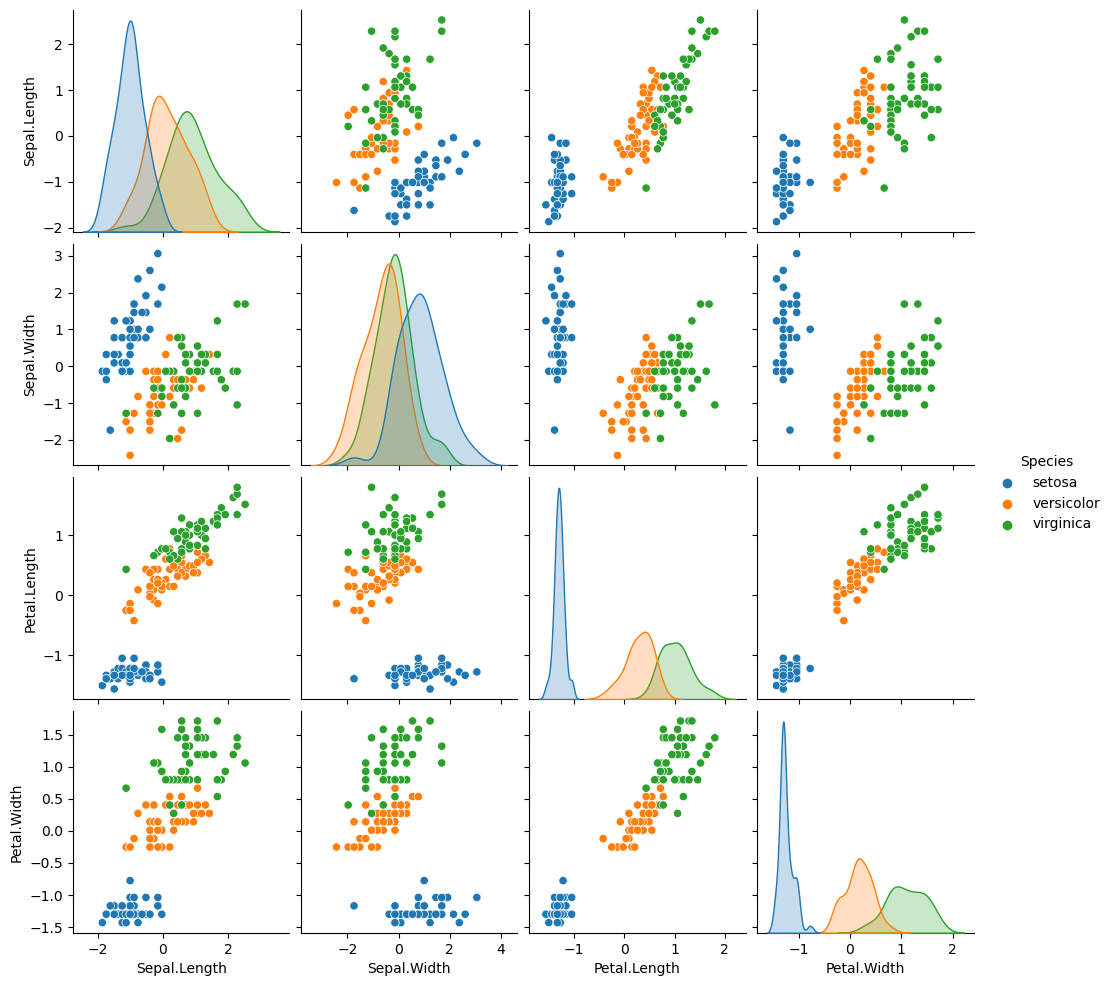

In [6]:
sns.pairplot(data=iris_scaled, hue="Species")

## Supervised Learning Case

Before we start with the actual clustering, let's revisit the classification methods we talked about during last weeks' workshops and see how well they are doing in terms of classification error. For that, we are importing a `kNN classifier` from the sklearn library and have a look at the confusion matrix and the classification report.

kNN has some intuitive parallels to k-means clustering (see lecture material).

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [8]:
# Note that we are not doing a train-test-split or other advanced methods here; this is not a valid approach for a real supervised learning projects!
model_neigh = KNeighborsClassifier(n_neighbors=5)
model_neigh.fit(X_scaled,y)

KNeighborsClassifier()

In [9]:
y_pred = model_neigh.predict(X_scaled)

To review the performance of our classifier we check relevant test metrics, which you are familiar with by now. We use the `classification_report` class to return a neat summary of the most important classification metrics. We also review the previously discussed `confusion_matrix`.

In [10]:
iris["SpeciesPred"] = y_pred
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        49
  versicolor       0.92      0.96      0.94        49
   virginica       0.96      0.92      0.94        48

    accuracy                           0.96       146
   macro avg       0.96      0.96      0.96       146
weighted avg       0.96      0.96      0.96       146



In [11]:
classification_conf_matrix = confusion_matrix(y,y_pred)
classification_conf_matrix

array([[49,  0,  0],
       [ 0, 47,  2],
       [ 0,  4, 44]])

## Unsupervised Learning Case - K-Means
Now, let's drop the labels and just have a look at the given features. How would we group the datapoints for the different observed flowers?
In a typical unsupervised learning case we normally just have a rough idea of how many clusters to expect.

Three approaches are commonly applied:
1. Use expert knowledge
1. Plot residual loss for different numbers of clusters, find 'elbow' and select corresponding number of clusters
1. Use hierarchical clustering to detect suitable branching and corresponding number of clusters

We will focus on the residual loss as a selection criterion for now. In practice, a combination of all three methods is often used.

In [13]:
from sklearn.cluster import KMeans

In [14]:
k_max = 20  # we have 147 datapoints, more than 20 clusters are definitely not reasonable!

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

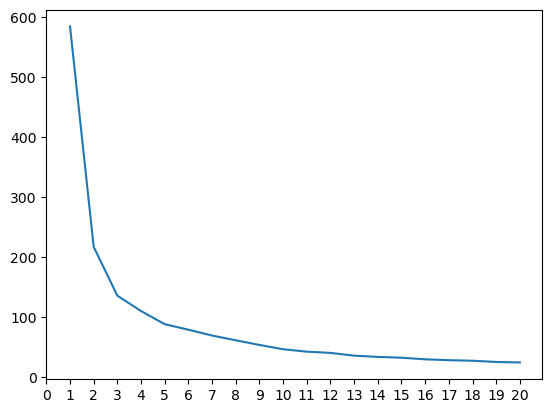

In [15]:
plt.plot(clusters, losses)
plt.xticks(range(k_max+1))
plt.show()

Let's zoom in in the good region by limiting the x-axis

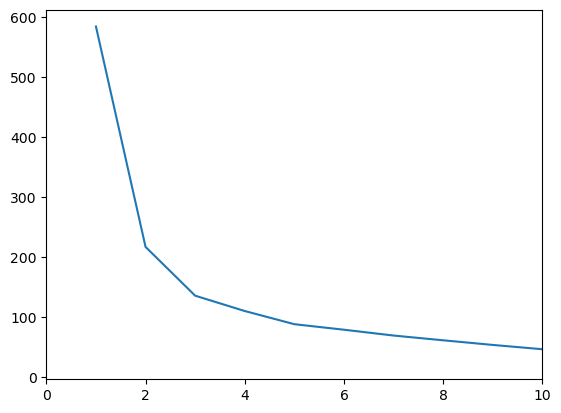

In [16]:
plt.plot(clusters, losses)
plt.xlim([0,10])
plt.show()

From this plot we would expect a good amount of clusters to lie in the region of two to five. Of course, we know that the correct answer is 3 (i.e., one per each species). However, in a true unsupervised learning setting there is no frame of reference and we'd need to draw on several indicators (quantitative and qualitative) to settle on a final number of clusters. For illustrative purposes let's select k=2, the minimum sensible choice.

In [17]:
# re-fit algorithm
two_means = KMeans(n_clusters=2)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's plot the results.

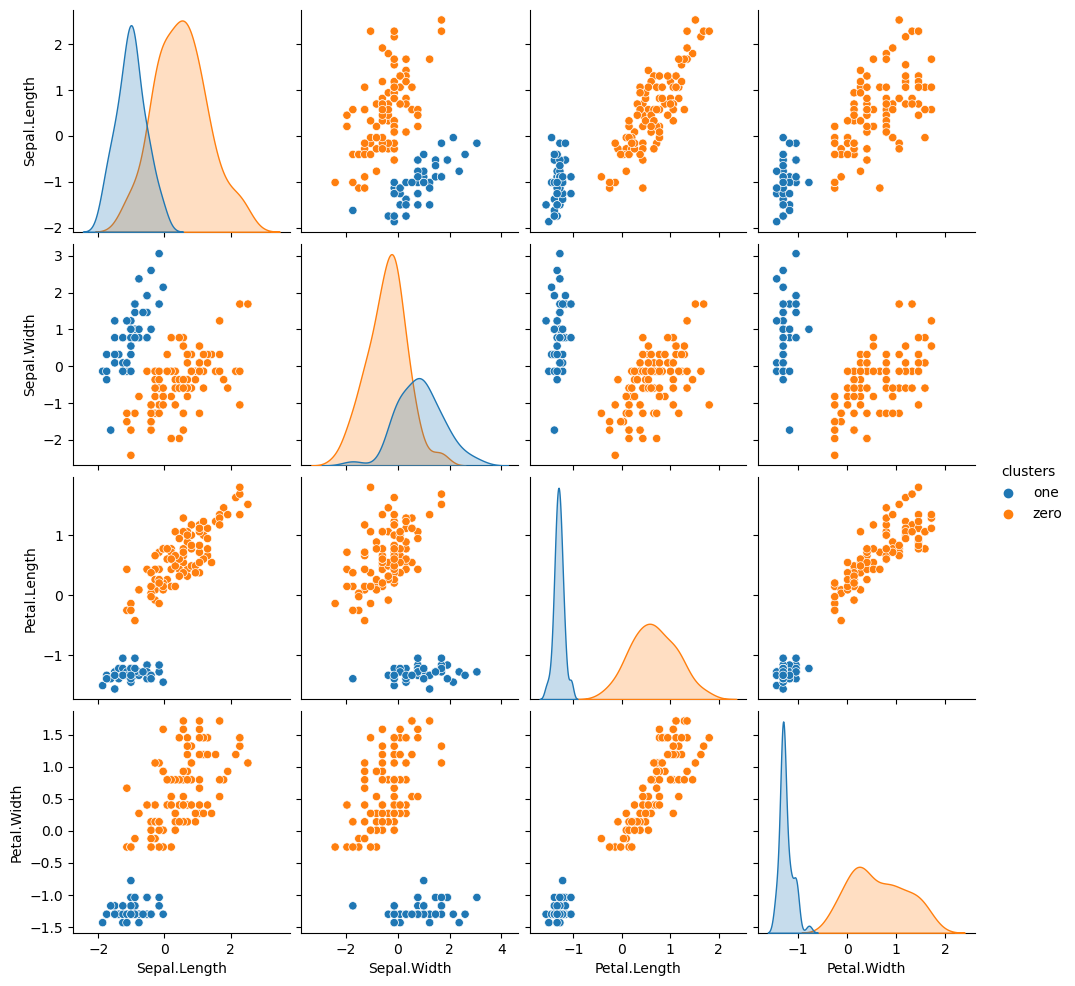

In [18]:
numbers = ["zero", "one", "two", "three","four","five"]
iris_scaled["clusters"] = two_means.predict(X_scaled)
iris_scaled["clusters"] = iris_scaled["clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="clusters")

Now let's do this for the "correct" number of cluster, i.e., three.

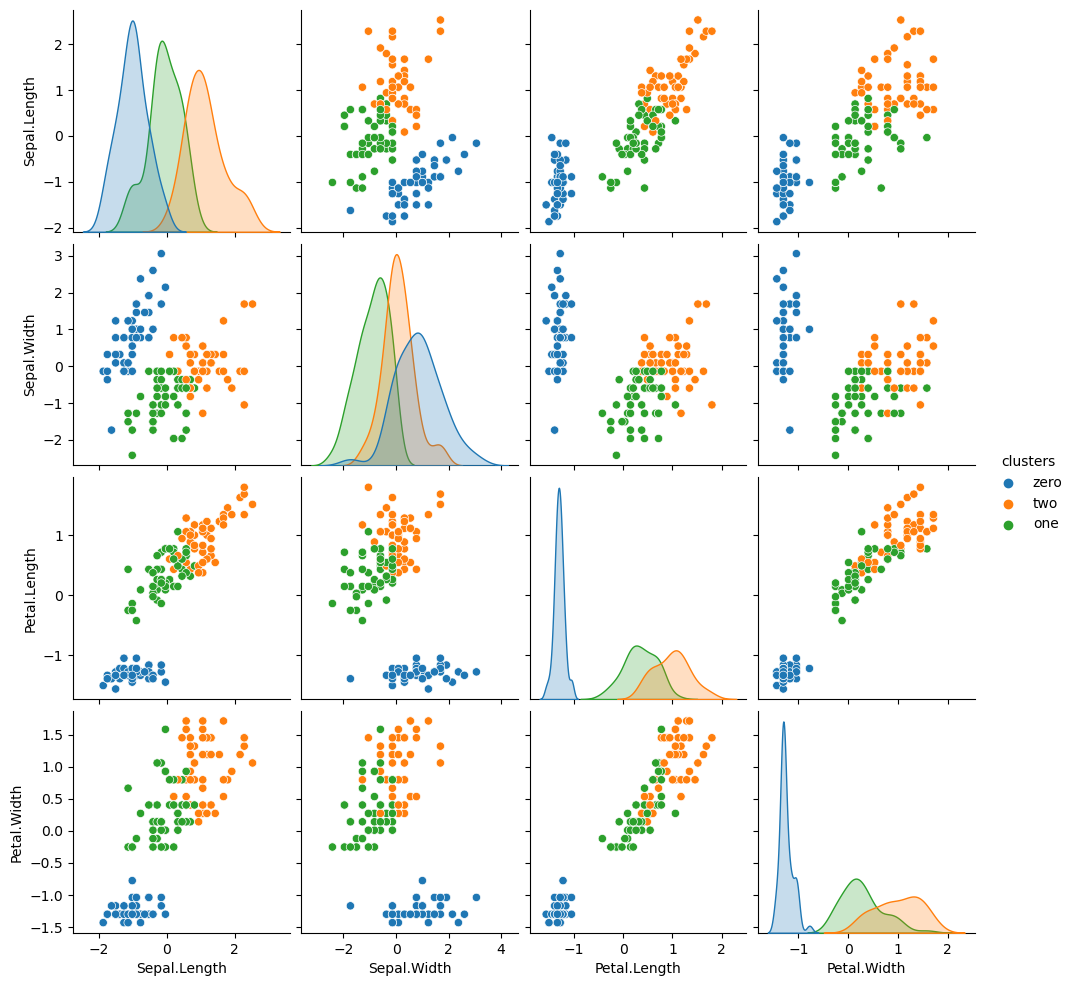

In [19]:
three_means = KMeans(n_clusters=3)
three_means.fit(X_scaled)
iris_scaled["clusters"] = three_means.predict(X_scaled)
iris_scaled["clusters"] = iris_scaled["clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="clusters")

How would k=5 fare?

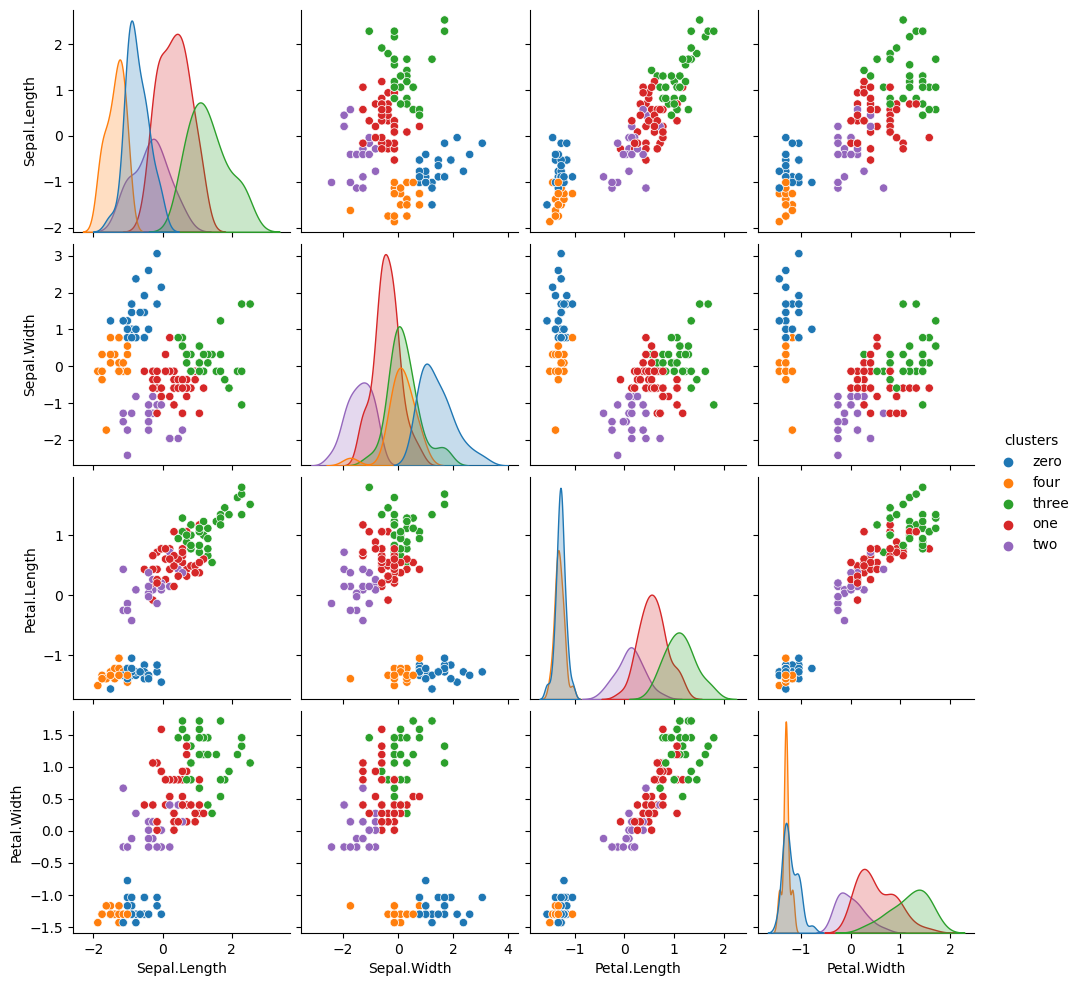

In [20]:
five_means = KMeans(n_clusters=5)
five_means.fit(X_scaled)
iris_scaled["clusters"] = five_means.predict(X_scaled)
iris_scaled["clusters"] = iris_scaled["clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="clusters")

From inspection, we can tell that k=5 achieves relatively poorer inter-cluster separation (e.g., 1 and 3 are very similar). From these analyses, a data scientist would most likely select 3 clusters.

There are other quantitative measures to assess cluster validity. Some examples include:
- Silhouette Coefficients: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
- Calinski-Harabasz Scores: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html

## Principal Component Analysis (PCA) Re-visited
In the case of the iris dataset, we have just four features - an amount we can still easily manage. But imagine we have a much larger features space. Then, it might be necessary to reduce the dimensionality of our dataset. Also, we gain another advantage: We can visualize the data more easily! As you have seen above, already with just 4 dimensions it is hard to visualize our data in a meaningful way. The size of a pairplot increases quadratically with the number of features. For four features we have sixteen plots (more than you should expect any stakeholder to have a look at/understand...), but for 10 features it is already a hundred - way more than you would like to have to look at!

So, how do we reduce the dimensionality of our dataset without losing too much information? (unfortunately, we are always losing some.)


Principal component analysis (PCA) is the way to go! Using PCA, we are looking at our data and trying to find a projection which keeps most of the variance within the data. As this is a little theoretical, let's have a quick look at a graphical example:

![pca](pca.png)

Here, our data originally had two dimensions and is reduced onto just one dimension. As you can see, most of the variance of our data is conserved. If the datapoints are very crooked in space, it is a little harder to find the "principal components". For this, there a advanced options like for example Kernel-PCA (which we are not talking about in this course). 

Furthermore, there is one more important application for PCA: When there are more features than records in your dataset, you can reduce the dimensionality of your dataset to the number of records without losing any information! So if you have 1 million features but only 100 records, then it is sufficient to look at only the first 100 principal components and you will not have lost any variance. Still, it can be useful to reduce the number of dimensions further in case you do not lose too much variance.

As a rule of thumb, there should be at least 95% of the original variance left in the dataset. Let's now run a PCA on our iris dataset and have a look at the principal components.

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

In [22]:
print(pca.explained_variance_ratio_[0])

0.7271625579405164


In [23]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

In [24]:
print(pca2.explained_variance_ratio_)

#sum explained variance over all PCA components
print(sum(pca2.explained_variance_ratio_))

[0.72716256 0.23108571]
0.9582482724875817


Using only two principal components, we still have approx. 96% of our variance, so we can assume that the transformed dataset is a good approximation of our original dataset. Let's now have a closer look at how each of these two principal components is composed.

In [25]:
print(pca2.components_)
print(list(X_scaled_df.columns)[:4])

[[ 0.5215428  -0.26325264  0.58136097  0.56631315]
 [ 0.37682198  0.92393738  0.01878068  0.0631838 ]]
['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']


In [26]:
X_scaled

array([[-0.8932439 ,  1.00205068, -1.33301846, -1.30085598],
       [-1.13746414, -0.13913028, -1.33301846, -1.30085598],
       [-1.38168438,  0.3173421 , -1.39000842, -1.30085598],
       [-1.5037945 ,  0.08910591, -1.27602851, -1.30085598],
       [-1.01535402,  1.23028687, -1.33301846, -1.30085598],
       [-0.52691354,  1.91499545, -1.1620486 , -1.03870971],
       [-1.5037945 ,  0.77381449, -1.33301846, -1.16978285],
       [-1.01535402,  0.77381449, -1.27602851, -1.30085598],
       [-1.74801475, -0.36736647, -1.33301846, -1.30085598],
       [-1.13746414,  0.08910591, -1.27602851, -1.43192912],
       [-0.52691354,  1.45852306, -1.27602851, -1.30085598],
       [-1.25957426,  0.77381449, -1.21903855, -1.30085598],
       [-1.25957426, -0.13913028, -1.33301846, -1.43192912],
       [-1.87012487, -0.13913028, -1.50398833, -1.43192912],
       [-0.03847305,  2.14323164, -1.44699837, -1.30085598],
       [-0.16058317,  3.05617641, -1.27602851, -1.03870971],
       [-0.52691354,  1.

In [27]:
iris_pca = pd.DataFrame(X_pca2, columns=["First PC", "Second PC"], index=iris.index)
iris_pca["Species"] = iris["Species"]
iris_pca.head()

,First PC,Second PC,Species
number,,,
1,-2.241314,0.482010,setosa
2,-2.068267,-0.664397,setosa
3,-2.348937,-0.335743,setosa
4,-2.286276,-0.590492,setosa
5,-2.365084,0.646872,setosa


Before running a clustering algorithm on the reduced data, let's first have a look at what we would have seen using only one principal component!

<Axes: xlabel='Species', ylabel='First PC'>

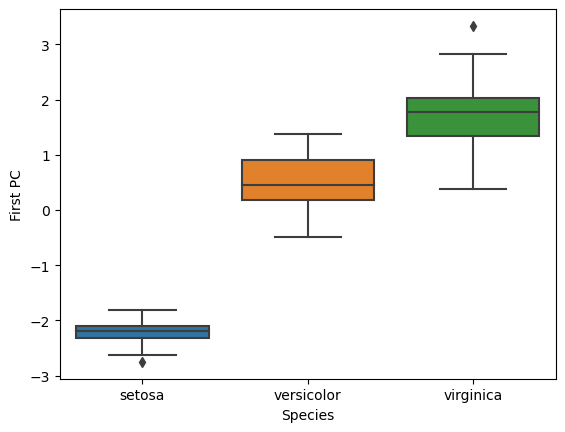

In [28]:
sns.boxplot(x="Species", y="First PC", data=iris_pca)

We are (as expected) already able to differentiate between *setosa* and the other two types easily using just the first principal component. There is a clear difference between the core elements of the other two clusters, but it is not possible to completely differentiate between them.

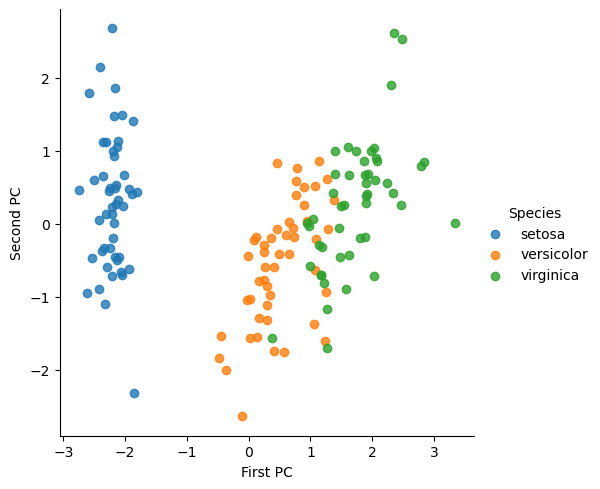

In [29]:
sns.lmplot(x="First PC", y="Second PC", data=iris_pca, fit_reg=False, hue="Species")

Let's now use K-means again to find clusters in this reduced 2-dimensional space! 

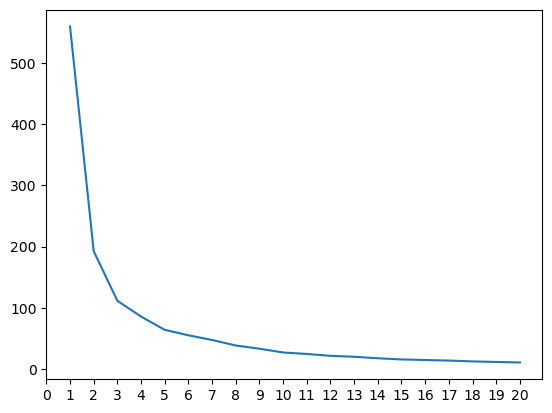

In [30]:
pca_clusters = []
pca_losses = []

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(X_pca2)
    pca_clusters.append(i+1)
    pca_losses.append(model.inertia_)
    
plt.plot(pca_clusters, pca_losses)
plt.xticks(range(k_max+1))
plt.show()

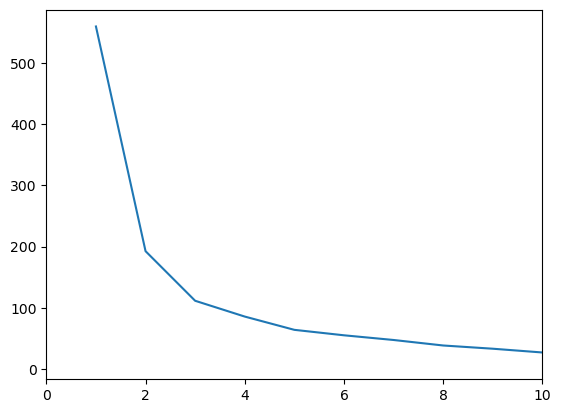

In [31]:
# zoom into the good region
plt.plot(pca_clusters, pca_losses)
plt.xlim([0,10])
plt.show()

In [32]:
pca_three_means = KMeans(n_clusters=3)
pca_three_means.fit(X_pca2)

KMeans(n_clusters=3)

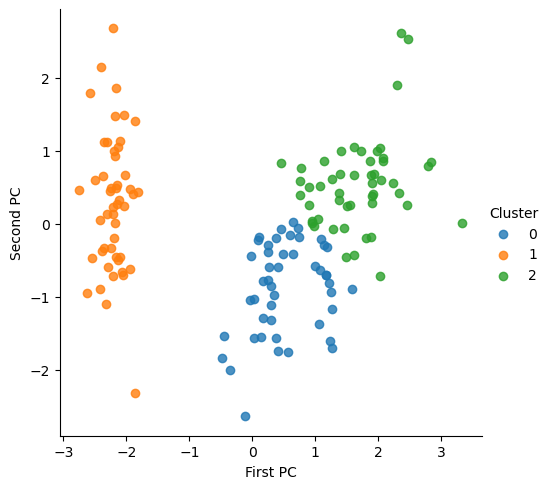

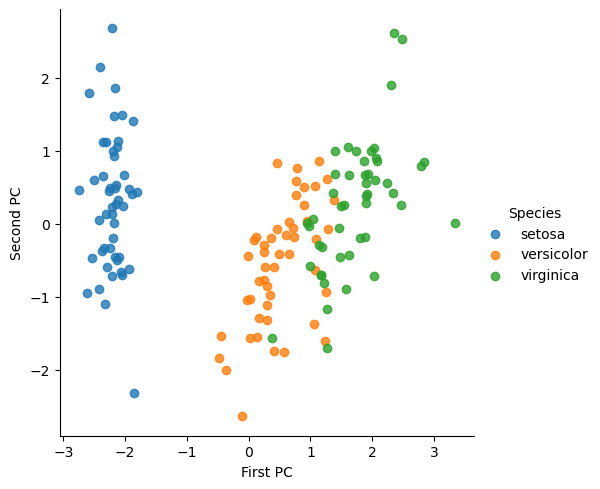

In [33]:
iris_pca["Cluster"] = pca_three_means.predict(X_pca2)

# clustering result
sns.lmplot(x="First PC", y="Second PC", hue="Cluster", data=iris_pca, fit_reg=False)
# actual classes
sns.lmplot(x="First PC", y="Second PC", hue="Species", data=iris_pca, fit_reg=False)

**Exercise:** Use all methods for unsupervised learning shown here and try to find clusters in the (pre-prepared) cancer dataset! How many principal components do you need? Can you still plot your data in a meaningful way? Would you have chosen the number of clusters as 2 without knowing that there are only two cancer types?

In [36]:
# load data
cancer = pd.read_csv('breast_cancer.csv', index_col="id")
cancer.dropna(axis=1, inplace=True)
cancer_wo_target = cancer.drop("diagnosis", axis=1)

cancer_wo_target.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [37]:
### YOUR CODE HERE

# scale features
scaler = StandardScaler()
cancer_scaled = pd.DataFrame(scaler.fit_transform(cancer_wo_target))

# run PCA to reduce dimensionality (hint: 10 PCs should be fine)
pca = PCA(n_components=10)
cancer_scaled_pca = pca.fit_transform(cancer_scaled)

# 10 seems good
sum(pca.explained_variance_ratio_)

0.9515688143342821

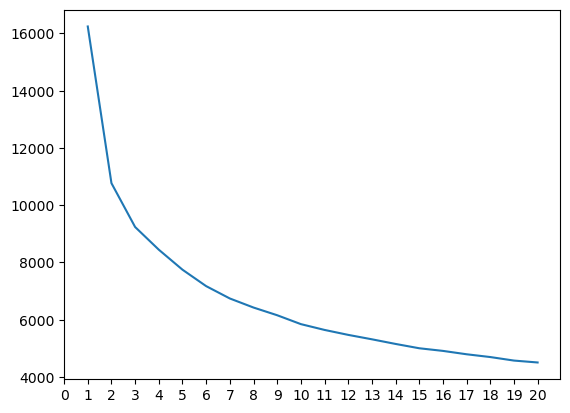

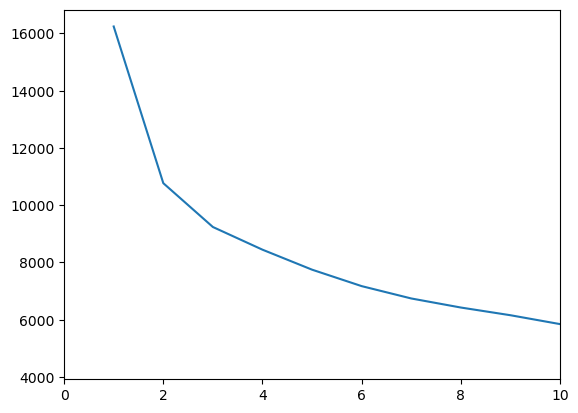

In [38]:
### YOUR CODE HERE

# determine number of clusters via elbow method
pca_clusters = []
pca_losses = []

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(cancer_scaled_pca)
    pca_clusters.append(i+1)
    pca_losses.append(model.inertia_)
    
plt.plot(pca_clusters, pca_losses)
plt.xticks(range(k_max+1))
plt.show()

plt.plot(pca_clusters, pca_losses)
plt.xlim([0,10])
plt.show()

In [39]:
# train model for chosen n clusters (i.e., 2)
n=2
cancer_two = KMeans(n_clusters=n)
cancer_two.fit(cancer_scaled_pca)

KMeans(n_clusters=2)

In [40]:
# produce joint df
cancer_scaled_pca_df = pd.DataFrame(cancer_scaled_pca, index=cancer.index)
cancer_scaled_pca_df.columns = ["PC"+str(column+1) for column in cancer_scaled_pca_df.columns]
cancer_scaled_pca_df["Cluster"] = cancer_two.predict(cancer_scaled_pca)
cancer_scaled_pca_df["Diagnosis"] = cancer["diagnosis"]
cancer_scaled_pca_df.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Cluster,Diagnosis
id,,,,,,,,,,,,
842302,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398405,-0.157118,-0.877396,0,M
842517,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013359,0.240989,-0.711908,1.106996,0,M


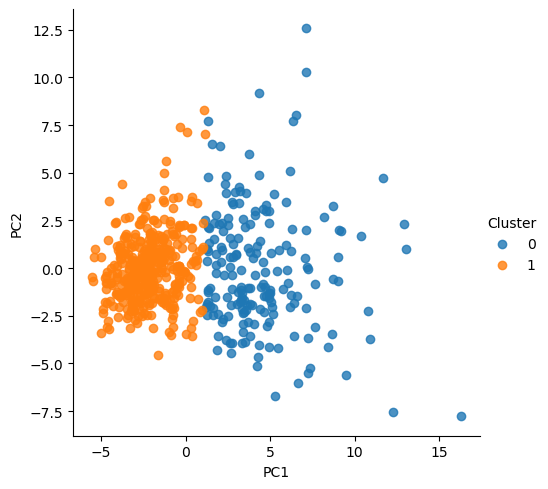

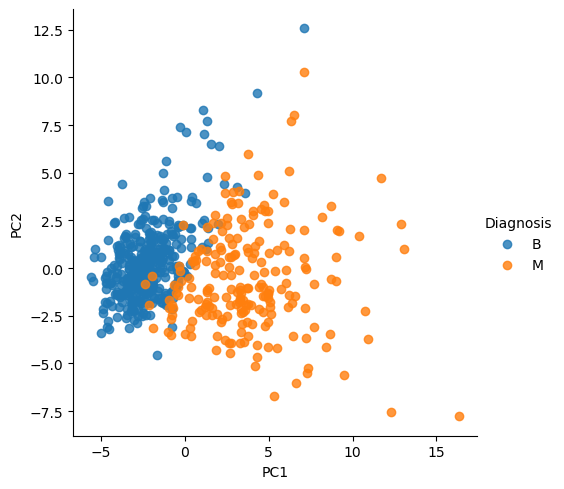

In [41]:
# visualize
sns.lmplot(x="PC1", y="PC2", data=cancer_scaled_pca_df, fit_reg=False, hue="Cluster")
sns.lmplot(x="PC1", y="PC2", data=cancer_scaled_pca_df, fit_reg=False, hue="Diagnosis",hue_order=["B","M"])

## `Hierarchical Clustering`

Unlike K-Means, hierarchical clustering defines step-wise decision rules for how to seperate the data into clusters. This has the advantage that it is more resembling the human decision making process and is therefore very intuitive for stakeholders to understand. 


Let's have a look at how a supervised decision tree would look like for our iris dataset and then back this up with an unsupervised hierarchical clustering.

## Supervised Learning Case - Decision Trees for Classification

The supervised equivalent of hierarchichal clustering is decision tree classification which we will briefly re-visit in this section.

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model_tree = DecisionTreeClassifier(max_depth=2)
# we engineer a new feature here to enhance performance
X["Petal.Area"] = X["Petal.Length"]*X["Petal.Width"]
model_tree.fit(X, y)
y_pred_tree = model_tree.predict(X)

In [44]:
print(classification_report(y_true=y, y_pred=y_pred_tree))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        49
  versicolor       1.00      0.92      0.96        49
   virginica       0.92      1.00      0.96        48

    accuracy                           0.97       146
   macro avg       0.97      0.97      0.97       146
weighted avg       0.97      0.97      0.97       146



In [45]:
y.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

[Text(0.4, 0.8333333333333334, 'Petal.Area <= 2.13\ngini = 0.667\nsamples = 146\nvalue = [49, 49, 48]\nclass = setosa'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 49\nvalue = [49, 0, 0]\nclass = setosa'),
 Text(0.6, 0.5, 'Petal.Area <= 7.425\ngini = 0.5\nsamples = 97\nvalue = [0, 49, 48]\nclass = versicolor'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 45\nvalue = [0, 45, 0]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'gini = 0.142\nsamples = 52\nvalue = [0, 4, 48]\nclass = virginica')]

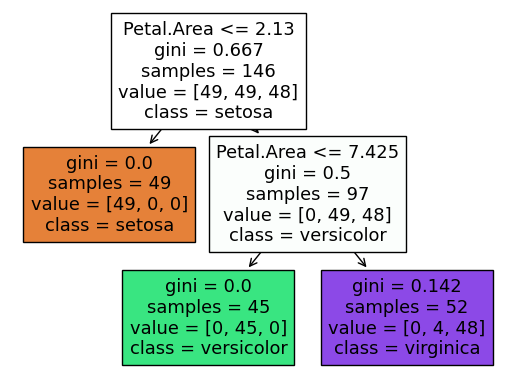

In [46]:
tree.plot_tree(model_tree, class_names=y.unique(), feature_names=X.columns, filled=True)

### Unsupervised Learning Case - Agglomerative/Hierarchichal Clustering

In [47]:
X_scaled = StandardScaler().fit_transform(X)

In [48]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

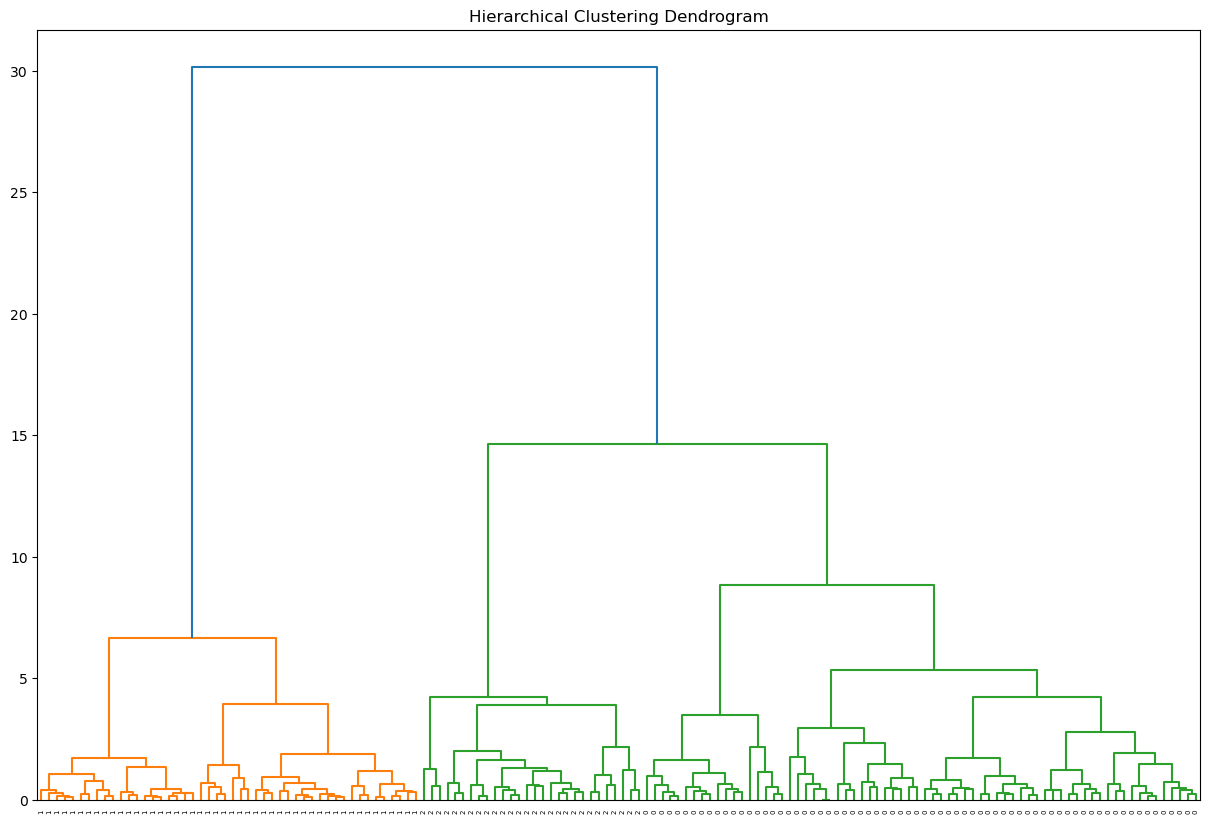

In [49]:
# plot
agglo = AgglomerativeClustering(compute_distances=True, n_clusters=3)
y_pred_agglo = agglo.fit_predict(X_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, labels=agglo.labels_)

In [50]:
iris_hierarchical = pd.DataFrame(X_scaled, columns=X.columns)
iris_hierarchical["Agglo_clusters"] = y_pred_agglo
iris_hierarchical["Species"] = iris["Species"].values

iris_hierarchical.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Petal.Area,Agglo_clusters,Species
0,-0.893244,1.002051,-1.333018,-1.300856,-1.165154,1,setosa
1,-1.137464,-0.139130,-1.333018,-1.300856,-1.165154,1,setosa
2,-1.381684,0.317342,-1.390008,-1.300856,-1.169416,1,setosa
3,-1.503795,0.089106,-1.276029,-1.300856,-1.160893,1,setosa
4,-1.015354,1.230287,-1.333018,-1.300856,-1.165154,1,setosa


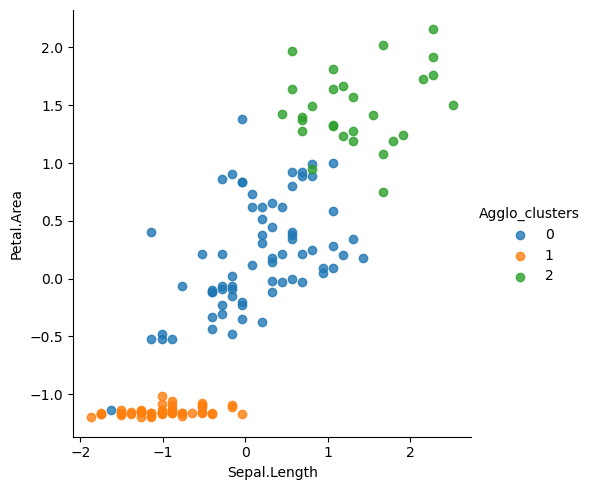

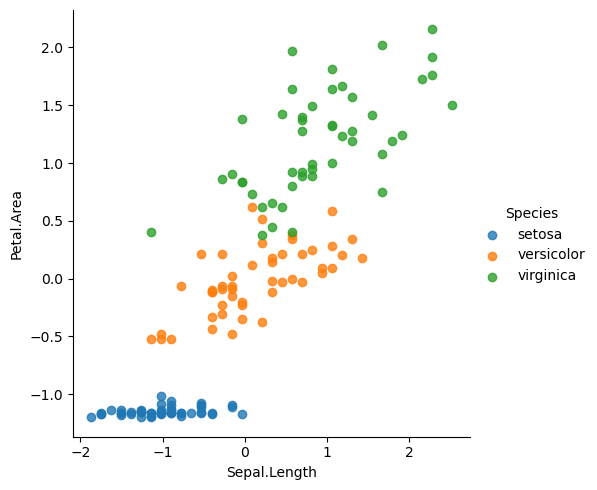

In [51]:
sns.lmplot(x="Sepal.Length", y="Petal.Area", data=iris_hierarchical, fit_reg=False, hue="Agglo_clusters")
sns.lmplot(x="Sepal.Length", y="Petal.Area", hue="Species", data=iris_hierarchical, fit_reg=False)

**End of Workshop Exercise:** Employ Hierarchichal Clustering on the `breastcancer` dataset

In [ ]:
### YOUR CODE HERE












---